<a href="https://colab.research.google.com/github/lillianpoland/hi-class/blob/main/LillPolaU4proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#code necessary to run the models
!pip install "preliz[full,notebook]"

In [2]:
import preliz as pz

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import arviz as az
import pymc as pm

##Data Set

In [27]:
#URL link that connects to the raw data within Github
url_2324 = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/basketball2324.csv'
data_2324 = pd.read_csv(url_2324)

# We want to be able to group by position in the future, so make Pos a category
data = pd.read_csv(url,dtype={'Pos':'category'})

# We only need to see the relevant columns
data = data[['Player','Pos', 'TRB',]]
data

,Player,Pos,TRB
0,Precious Achiuwa,PF-C,487
1,Bam Adebayo,C,737
2,Ochai Agbaji,SG,216
3,Santi Aldama,PF,352
4,Nickeil Alexander-Walker,SG,167
...,...,...,...
567,Thaddeus Young,PF,103
568,Trae Young,PG,149
569,Omer Yurtseven,C,208
570,Cody Zeller,C,112


In [28]:
# Creates an array of numerical labels for each basketball position
pos_idx = data.Pos.cat.codes.values

# Creates an array that has each unique string values of the basketball positions
pos_codes = data.Pos.cat.categories

#Creates a dictionary which PyMC can read
bask_coords = {"pos": pos_codes}

## Model



When the data is shown in a violin plot, it seems to have a positive skew, skewed right. This is why I made a hierarchal model with Skewnormal.

<Axes: ylabel='TRB'>

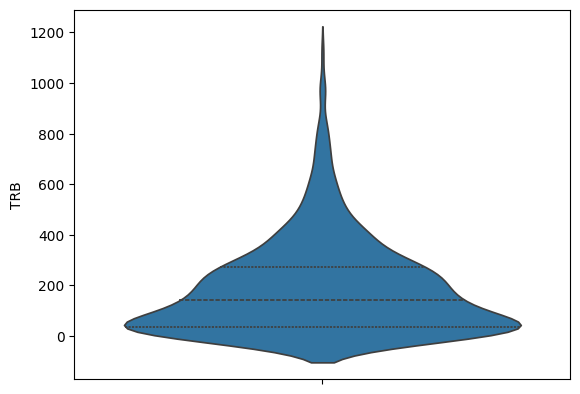

In [29]:
# visualizing data
sns.violinplot(data.TRB,inner='quart')

Now I will made the Skew Normal model, keeping all the positions together. This is to make sure the models match up. When plotting the posterior predictive check, it is aparent that it doesn't line up that well and an exponential model could work better.

In [30]:
with pm.Model(coords = bask_coords) as bask_model:
    #hyperpriors
    μ_mu = pm.Normal('μ_mu', mu = 0, sigma = 300)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 30)

    #priors
    μ = pm.Normal('μ',
                  mu = μ_mu,
                  sigma = μ_sd)

    σ = pm.HalfNormal('σ', sigma = 10)

    α = pm.Exponential('α', lam = 5)

    #skewnormal
    _ = pm.SkewNormal('trb', mu = μ, sigma = σ, alpha = α, observed = data.TRB.values)

    #target_accept (default = 0.8) controls the sampler's acceptance probability.
    #Increasing it can reduce divergences
    idata_bask = pm.sample(target_accept = 0.95)

Output()

Output()

ERROR:pymc.stats.convergence:There were 35 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

<Axes: xlabel='trb'>

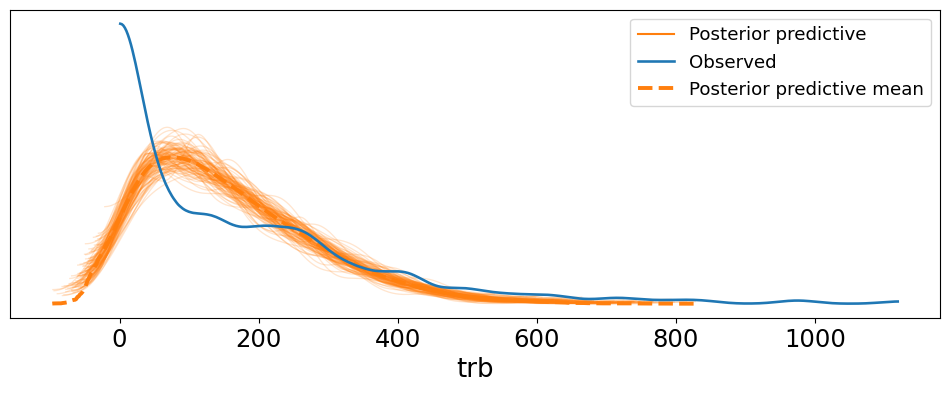

In [31]:
pm.sample_posterior_predictive(idata_bask, model=bask_model, extend_inferencedata=True)
az.plot_ppc(idata_bask, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

After analyzing this model (the skew normal), I decided to try an exponential model. An exponential model is always positive, accounting for this skew, potentially making it the right fit. When I ran this model, it fit the data much better than the Skew Normal.

In [32]:
with pm.Model(coords = bask_coords) as bask_model:
    #hyperpriors
    a = pm.Gamma('a', alpha = 1, beta = 1)
    b = pm.Gamma('b', alpha = 1, beta = 1)

    #priors
    λ = pm.Gamma('λ', alpha = a, beta = b)

    #exponential
    _ = pm.Exponential('trb', lam = λ, observed = data.TRB.values)

    #target_accept has a default of 0.8. Increasing it makes us less likely to have divergences
    idata_bask = pm.sample(target_accept = 0.95)

Output()

Output()

Output()

(0.0, 1100.0)

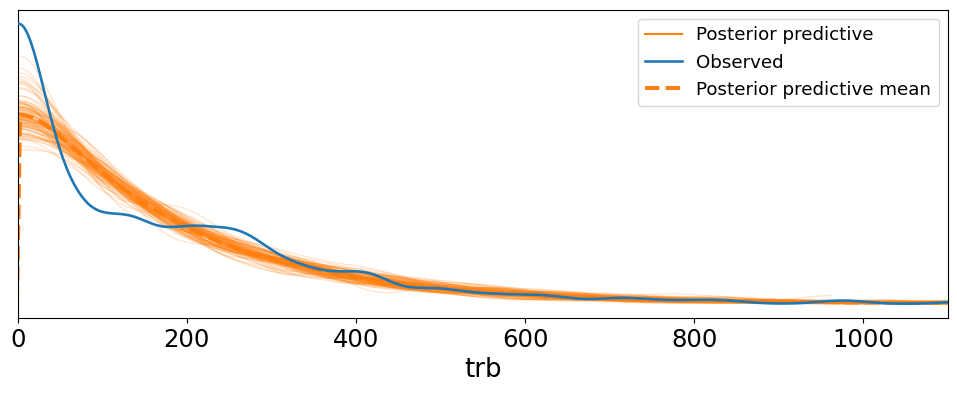

In [33]:
pm.sample_posterior_predictive(idata_bask, model=bask_model, extend_inferencedata=True)
ax = az.plot_ppc(idata_bask, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
ax.set_xlim(0, 1100)

Now that a model has been found thay is a better fit, the posterior will be seperated by position. This allows for different priors for each position, but one hyperprior for all of them.

In [34]:
with pm.Model(coords = bask_coords) as bask_model:
    #hyperpriors
    a = pm.Gamma('a', alpha = 1, beta = 1)
    b = pm.Gamma('b', alpha = 1, beta = 1)

    #priors
    λ = pm.Gamma('λ', alpha = a, beta = b, dims = "pos")

    #skewnormal
    _ = pm.Exponential('trb', lam = λ[pos_idx], observed = data.TRB.values)

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_bask = pm.sample(target_accept = 0.95)

Output()

Output()

##Analysis

Trace plots show the likely values for our model's parameters. To make the plot easier to read, I adjusted the x-axis for the λ parameter. These plots show the results for the exponential model, where each basketball position has its own prior. When I look at the plots for λ, I can see some positions have a very clear peak, meaning a high probability for specific values, while other positions have more spread-out distributions, which could mean more uncertainty.

(0.0, 0.015)

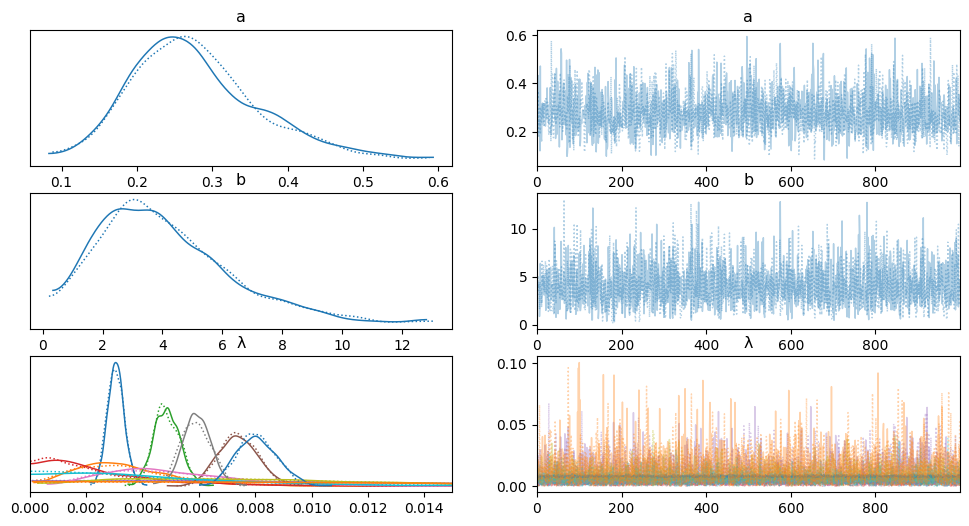

In [35]:
#az.plot_trace(idata_bask) but limiting the graph of the λ so it is easier to read
az.plot_trace(idata_bask)[2,0].set_xlim([0, .015])

The rhat values below indicate good convergence, as they are close to the ideal value of 1.

In [37]:
az.rhat(idata_bask) #ideally between 1 and 1.001. anything about 1.1 is not good

<xarray.Dataset> Size: 352B
Dimensions:  (pos: 12)
Coordinates:
  * pos      (pos) <U5 240B 'C' 'C-PF' 'PF' 'PF-C' ... 'SF-SG' 'SG' 'SG-PG'
Data variables:
    a        float64 8B 1.0
    b        float64 8B 0.9995
    λ        (pos) float64 96B 1.0 1.002 1.001 1.0 ... 1.0 1.003 1.001 1.001

The forest plot below displays the λ values for each poisition. We need to calculate the reciprocal of these values to get the actual predictions.

array([<Axes: >], dtype=object)

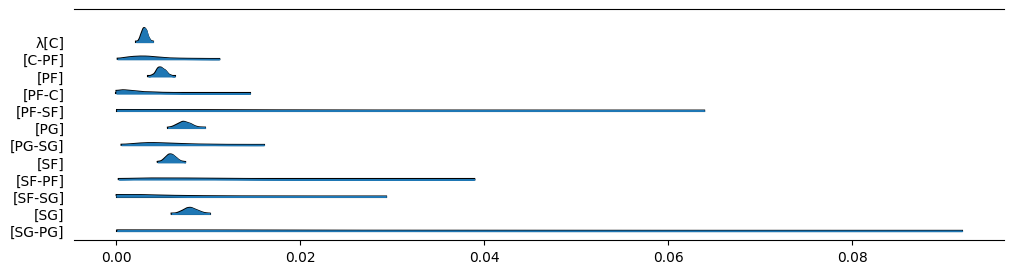

In [38]:
az.plot_forest(idata_bask, var_names=['λ'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

The code below calculates the mean of the lambda variable for each position then takes the reciprocal of each mean.

In [39]:
#retrieving the array of means

posterior = idata_bask.posterior
lambda_variable = posterior['λ']
mean_lambda = lambda_variable.mean(dim=['chain', 'draw'])
mean_array = mean_lambda.values

#print(mean_array)

#creating the array of reciprocals

reciprocal_array = []
for value in mean_array:
    reciprocal = 1 / value
    reciprocal_array.append(reciprocal)

#print (reciprocal_array)

# go through each of the positions and print it next to the 1/lamda
# print(pos_codes)
for i in range(len(pos_codes)):
    position = pos_codes[i]
    reciprocal = reciprocal_array[i]
    print(f'{position}: {reciprocal}')

C: 326.778179799862
C-PF: 292.5587879198149
PF: 205.5197995479262
PF-C: 388.4248105125083
PF-SF: 86.208533953683
PG: 134.95016292082428
PG-SG: 196.82343852638678
SF: 168.93619797902076
SF-PF: 113.13150950254142
SF-SG: 209.78027922120452
SG: 124.09260434032713
SG-PG: 64.38241323126746


Now it can be shown in a bar graph.

<BarContainer object of 12 artists>

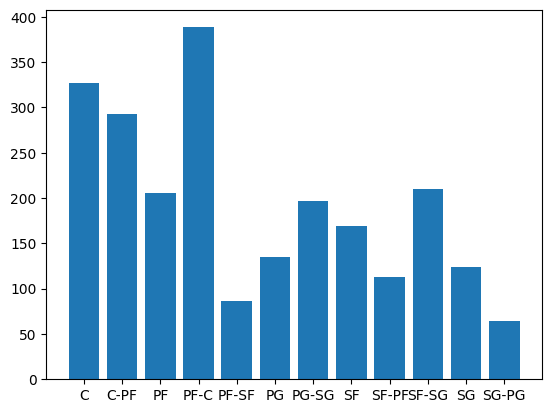

In [40]:
plt.bar(pos_codes, reciprocal_array)

## Conclusion

Position key:

Center (C)

Power Forward (PF)

Small Forward (SF)

Point Guard (PG)

Shooting Guard (SG)

Centers and power forwards are normally positioned near the basket and are expected to have higher TRB. The bar graph confirms this. Guards normally handle and ball and orchestrate plays, leading to lower rebounding numbers. This is also reflected on the bar graph. The alignment between basketball knowledge and the model's prediction suggests that the model is performing well.
